In [1]:
import numpy as np
import jupyter_helper
import QUANTAXIS as QA
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
import os
import sys
import talib
import pandas as pd
from talib import MA_Type
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
from tqdm import tqdm_notebook
from finance_ai_py import quantaxis_ext
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

C:\Users\GuQiang\AppData\Local\conda\conda\envs\finance35\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [2]:
s,e=jupyter_helper.get_start_end_date()
benchmark_code=jupyter_helper.get_benchmark_code()
stock_code='600436'

## 原始数据

In [9]:
stock_df=jupyter_helper.get_talib_stock_daily(stock_code,s,e,norms=['volume','amount'])

In [10]:
def create_new_df(stock_df,days):
    '''为stock_df增加列，列数根据days设置，增加day_1,day_2等列'''
    stock_df_copy=stock_df.copy()
    for i in range(1,days+1):
        stock_df_copy['day_{}'.format(i)]=stock_df_copy.shift(i*-1).close
    return stock_df_copy

## 根据固定的随机数种子拆分训练集和测试集

In [20]:
DAYS=5#预测X天的数据
stock_df_processed=create_new_df(stock_df,DAYS)
stock_df_processed.shape
# stock_df.shift(1).close

(3210, 87)

In [21]:
columns_days=[column for column in stock_df_processed.columns if 'day_' in column]
# columns_days#待预测的列的列头

In [22]:
X=stock_df_processed[:-DAYS].drop(columns=columns_days)
y=stock_df_processed[:-DAYS][columns_days]
X.shape,y.shape
_test_size = 0.1
_shuffle = False  # 对于时间序列来说，不能把数据打乱
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=_shuffle, test_size=_test_size)

In [23]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2884, 82), (321, 82), (2884, 5), (321, 5))

In [24]:
# y_test

In [25]:
enet = ElasticNet()
fit=enet.fit(X_train, y_train)

In [26]:
fit

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [27]:
fit.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

## 得分

In [28]:
fit.score(X_test,y_test)

0.9445341668045919

In [ ]:
# y_predict=fit.predict(X_test)
# y_predict

## 剩余的天数的计算结果

In [134]:
def get_prediction(fit,days,stock_df_processed):
    columns_days=[column for column in stock_df_processed.columns if 'day_' in column]
    test=fit.predict(stock_df_processed[-days:].drop(columns=columns_days))
    result=stock_df[-days:]['close'].reset_index().join(pd.DataFrame(test)).set_index('date')
    return result['close'][1:].to_frame().reset_index().join(result.iloc[0].to_frame('prediction')).set_index('date')

In [135]:
get_prediction(fit,DAYS,stock_df_processed)

,close,prediction
date,,
2018-12-07,86.85,87.077109
2018-12-10,85.00,87.307506
2018-12-11,89.19,87.388812
2018-12-12,88.88,87.373148
2018-12-13,92.34,87.554233
2018-12-14,91.88,87.558508
2018-12-17,89.65,87.491476
2018-12-18,89.75,87.376730
2018-12-19,86.97,87.188457


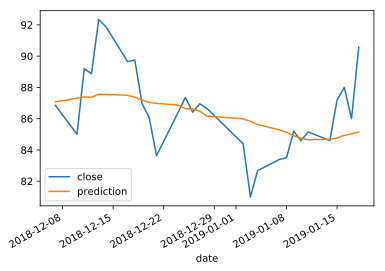

In [136]:
get_prediction(fit,DAYS,stock_df_processed).plot()

In [103]:
# test=fit.predict(stock_df_processed[-DAYS:].drop(columns=columns_days))
# # test

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [20]:
# #0列开始时预测未来+1天的close值
# result=stock_df[-DAYS:]['close'].reset_index().join(pd.DataFrame(test)).set_index('date')
# # result

In [21]:
# pppp=[]
# for i in range(1,len(result.index)):
#     ppp=[]
#     ppp.append(i)
#     for day in range(DAYS):
#         if day+i<len(result.index):
# #             ppp.append(result.iloc[i-1][day])
# #             ppp.append(result.iloc[day+i]['close'])
#             ppp.append(result.iloc[i-1][day]/result.iloc[day+i]['close']-1)
#         else:
#             ppp.append(np.nan)
#     pppp.append(ppp)
# pd.DataFrame(pppp)

In [22]:
# from pyecharts import Line
# line = Line('')
# line.add('实际值', stock_df[-DAYS:].index.date, stock_df[-DAYS:]['close'].shift(1), datazoom_extra_type='both',
#          is_datazoom_extra_show=True,
#          datazoom_extra_orient='horizontal')
# line.add('预测值', stock_df[-DAYS:].index.date, test[1:][0], datazoom_extra_type='both',
#          is_datazoom_extra_show=True,
#          datazoom_extra_orient='horizontal')

In [23]:
# result['close'][1:].to_frame().reset_index().join(result.iloc[0].to_frame('prediction')).set_index('date')

In [137]:
# result['close'][1:].to_frame().reset_index().join(result.iloc[0].to_frame('prediction')).set_index('date').plot()

## 不同天数得分

In [143]:
import logging, sys
logging.disable(sys.maxsize)

def get_scores(stock_df,DAYS):
    stock_df_processed=create_new_df(stock_df,DAYS)
    stock_df_processed.shape
    columns_days=[column for column in stock_df_processed.columns if 'day_' in column]
    X=stock_df_processed[:-DAYS].drop(columns=columns_days)
    y=stock_df_processed[:-DAYS][columns_days]
    X.shape,y.shape
    _test_size = 0.1
    _shuffle = False  # 对于时间序列来说，不能把数据打乱
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=_shuffle, test_size=_test_size)
    X_train.shape,X_test.shape,y_train.shape,y_test.shape
    enet = ElasticNet()
    fit=enet.fit(X_train, y_train)
    return [fit.score(X_test,y_test),fit]

In [144]:
scores={}
for i in tqdm_notebook(range(5,60,5)):
    scores[i]=get_scores(stock_df,i)

In [145]:
ks=[]
vs=[]
for k in sorted(list(scores.keys())):
    ks.append(k)
    vs.append(scores[k][0])
# ks,vs
from pyecharts import Bar
bar=Bar('预测时间长短与得分的关系')
bar.add('',ks,vs)
bar

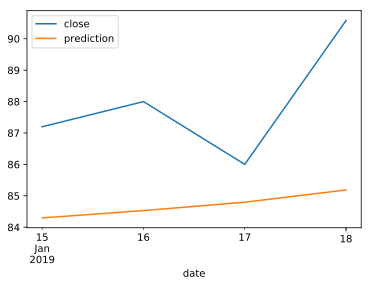

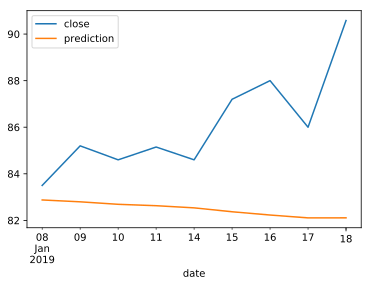

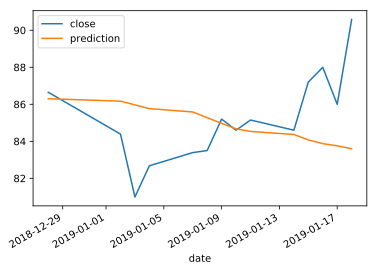

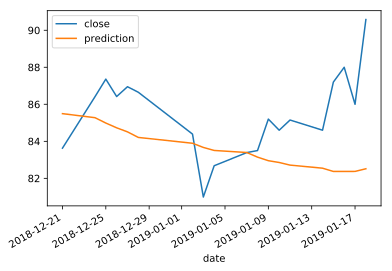

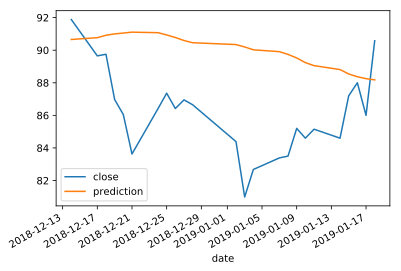

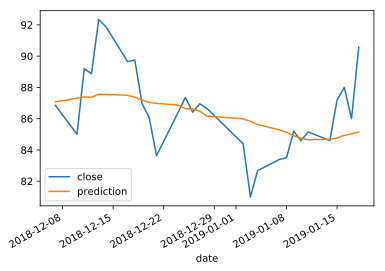

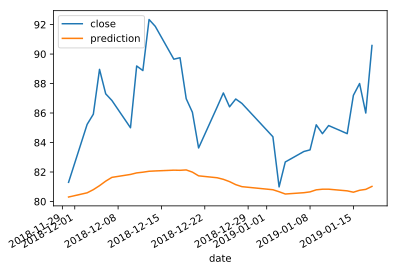

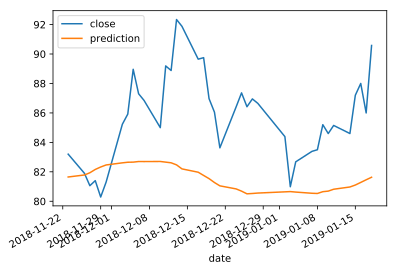

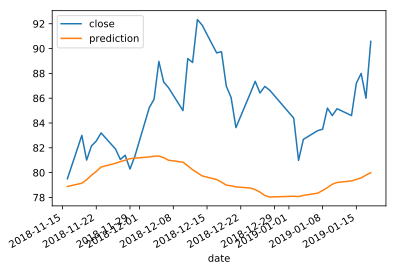

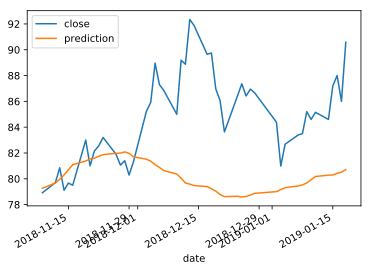

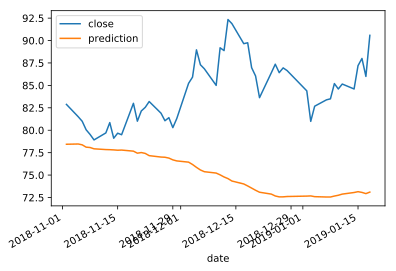

In [146]:
for k in sorted(list(scores.keys())):
    df=get_prediction(scores[k][1],k,create_new_df(stock_df,k))
    df.plot()